# LA Traffic EDA Project

### Notebook by Justin Valenzuela

#### Data was collected from Kaggle.com 
Link to Data: https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data/version/3

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
p = 'YlOrRd'
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data/la-traffic-data.csv')
#df.shape

# Trimming Columns for the Necessary Fields

In [3]:
df = df.drop(columns=['DR Number', # Searches by ID not necessary
                    'Area ID', # Can use Area Name instead
                    'Crime Code', # Uniformly Distributed tells us nothing
                    'Crime Code Description', # Also Uniformly Distributed
                    'Premise Code', # Can use Premise Description instead
                    'Date Reported', # Use Date Occured instead, TODO: Use date reported to see avg time accident is reported
                    'Neighborhood Councils (Certified)', # Not enough information to use meaningfully
                    'Census Tracts', # Not enough information to use meaningfully
                    'Council Districts', # Not needed
                    'MO Codes', # 18% of values are null, will be exluded
                    'LA Specific Plans'])  # 60%+ null, will be excluded 

df = df.dropna() # Dropping rows that have missing values, lost 96,739 rows
#df.shape # Lost roughly 20% of all rows, still have 385,912 left

# Cleaning up the Dataframe

In [4]:
# Renaming columns for better conventions

df.columns = ['date', 'hour', 'area', 'district', 'victim_age', 
              'victim_sex', 'race', 'premise_desc', 'address',
              'cross_street', 'location', 'zipcode', 'precinct_boundary']

In [5]:
# Making race dict for better descriptions of race

race_dict = {'A':'Other', 'B':'Black', 'C':'Chinese', 'F':'Filipino', 'H':'Hispanic',
             'I':'American Indian/Alaskan Native', 'J':'Japanese', 'K':'Korean',
             'O':'Other', 'P':'Pacific Islander', 'U':'Hawaiian', 'V':'Vietnamese',
             'W':'White', 'X':'Other', 'Z':'Asian Indian'}
# Adding in the race dictionary to the df
df.race = df.race.map(race_dict)

In [6]:
# Quick Breakdown of how many of each race

df.race.value_counts()

Hispanic                          151053
White                              98077
Other                              73718
Black                              56541
Korean                              3542
Filipino                            1269
Chinese                              631
Japanese                             243
Hawaiian                             196
Pacific Islander                     167
Vietnamese                           166
American Indian/Alaskan Native       128
Asian Indian                         109
Name: race, dtype: int64

In [7]:
# Converting Date to a more readable format

df.date = pd.to_datetime(df.date)
date_before = datetime.date(2019, 6, 1) # Graph later showed data entry for date was incompete
df = df[df.date < date_before] # Excluding any dates that are incomplete
# Making some new columns to use later in graphs
df['year'] = df.date.dt.year
df['day_of_week'] = df.date.dt.dayofweek
# Creating column called hour, converted from military time
df['hour'] = df.hour.astype(str) # Will drop 0's for values like 0800 so that the following line will work
df['hour'] = [i[:2] if len(i) == 4 else i[0] for i in df['hour']] # Takes the corresponding hour from the time
df['hour'] = df.hour.astype(int) # Cast back to an int for later analysis

In [8]:
# Creating new columns for lat and long
df['location'] = [ast.literal_eval(d) for d in df.location] # Safely evaluating the structure
df['longitude'] = [d['longitude'] for d in df.location] # Taking Longitude out/Creating its own column
df['latitude'] = [d['latitude'] for d in df.location] # Taking latitude out/Creating its own column
# Casting them to type float
df.longitude = df.longitude.astype(float)
df.latitude = df.latitude.astype(float)

In [9]:
df.index = pd.DatetimeIndex(df.date)

# Exploratory Analysis


### Accidents per day

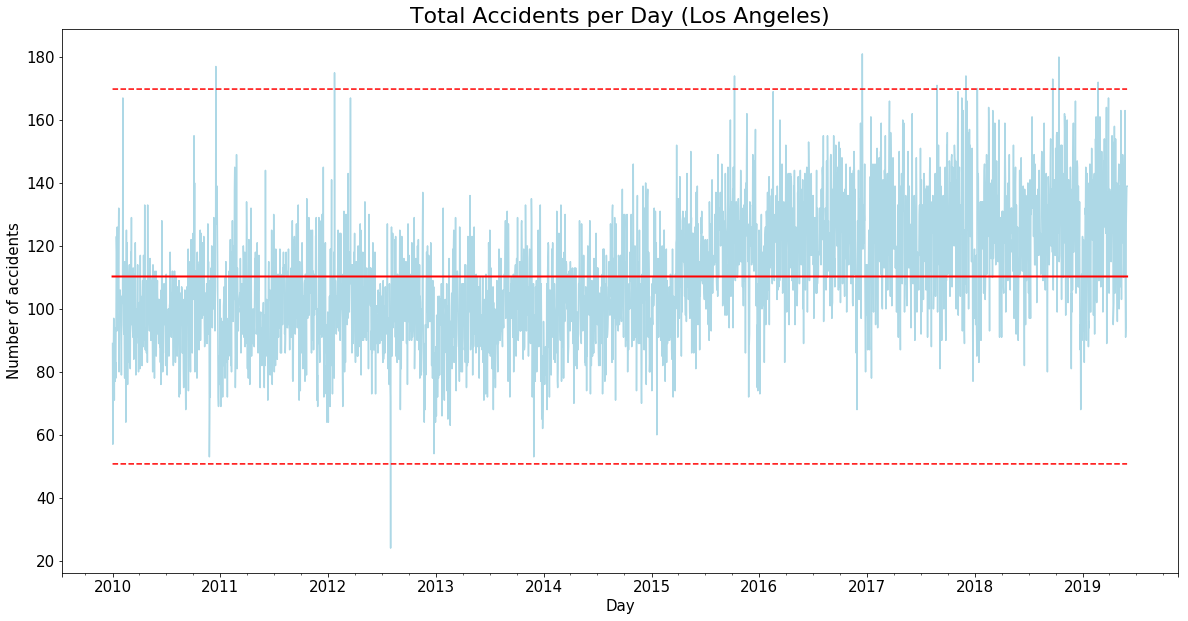

In [10]:
# Making graph to show total accidents per day

# Resampling with 'D' means I want to resample by day
accidents_per_day = pd.DataFrame(df.resample('D').size())
accidents_per_day['mean'] = df.resample('D').size().mean()
accidents_per_day['std'] = df.resample('D').size().std()

# upper control limit and lower control limit, 3 Standard deviations
UCL = accidents_per_day['mean'] + 3 * accidents_per_day['std']
LCL = accidents_per_day['mean'] - 3 * accidents_per_day['std']
plt.figure(figsize=(20,10))
df.resample('D').size().plot(label='Accidents per day', color='lightblue')
UCL.plot(color='red', ls='--', linewidth=1.5, label='UCL')
LCL.plot(color='red', ls='--', linewidth=1.5, label='LCL')
accidents_per_day['mean'].plot(color='red', linewidth=2, label='Average')
plt.title('Total Accidents per Day (Los Angeles)', fontsize=22)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Number of accidents', fontsize=15)
plt.tick_params(labelsize=15)

###  Accidents per Month

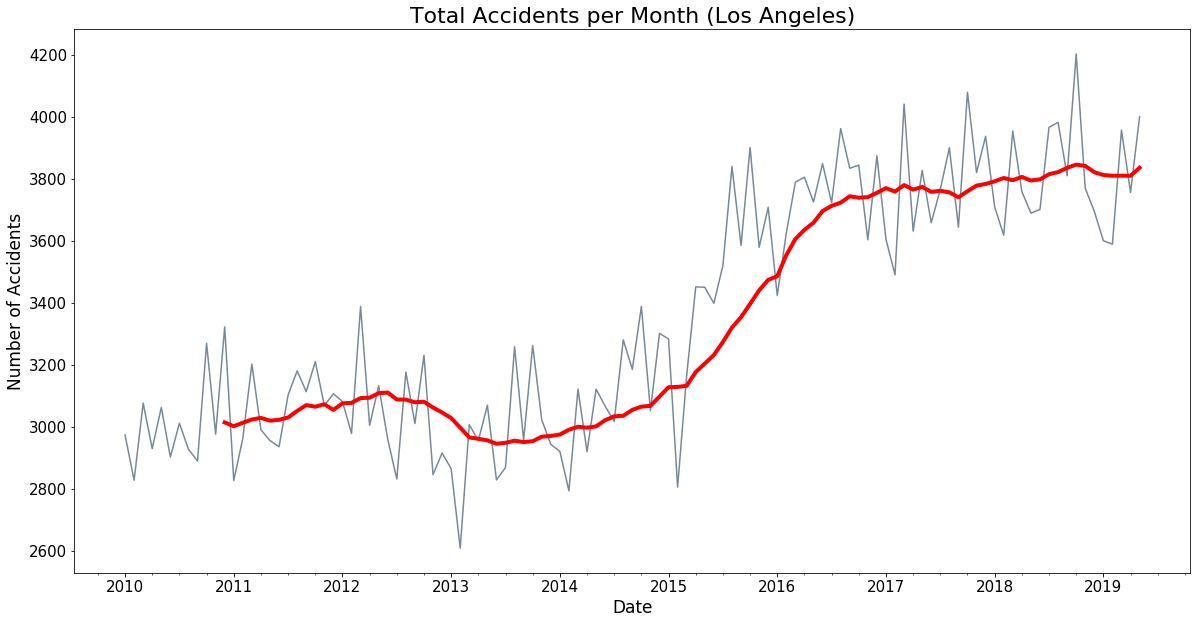

In [18]:
# Making graph to show total accidents per month

# Resampling with 'M' means I want to resample by month
month_df = df.resample('M').size()
plt.figure(figsize=(20,10))
month_df.plot(label='Total,  accidents per month', color='lightslategray')
# Specify background color for the axis/plot
month_df.rolling(window=12).mean().plot(color='red', linewidth=4, label='12-Months Average')
plt.title('Total Accidents per Month (Los Angeles)', fontsize=22)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Number of Accidents', fontsize=17)
plt.tick_params(labelsize=15)

In [12]:
print("Best Month {0}: {1}".format(month_df.idxmin(), month_df[month_df.idxmin()]))
print("Worst Month {0}: {1}".format(month_df.idxmax(), month_df[month_df.idxmax()]))

Best Month 2013-02-28 00:00:00: 2609
Worst Month 2018-10-31 00:00:00: 4204


##### Los Angeles' trend shows that the number of accidents have been increasing over the years
##### February 2013 had the lowest # of accidents whereas December 2018 had the most
##### Both of which can be visualized on the graph above

### Number of Total Accidents by Days of the Week

In [13]:
weekdaylist = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
week_df = pd.DataFrame(df["day_of_week"].value_counts()).sort_index()
week_df["day"] = weekdaylist
week_df.columns = ["Accident count", "Week Day"]
week_df

,Accident count,Week Day
0,52602,Sun
1,54288,Mon
2,54778,Tue
3,55499,Wed
4,60896,Thu
5,53431,Fri
6,47678,Sat


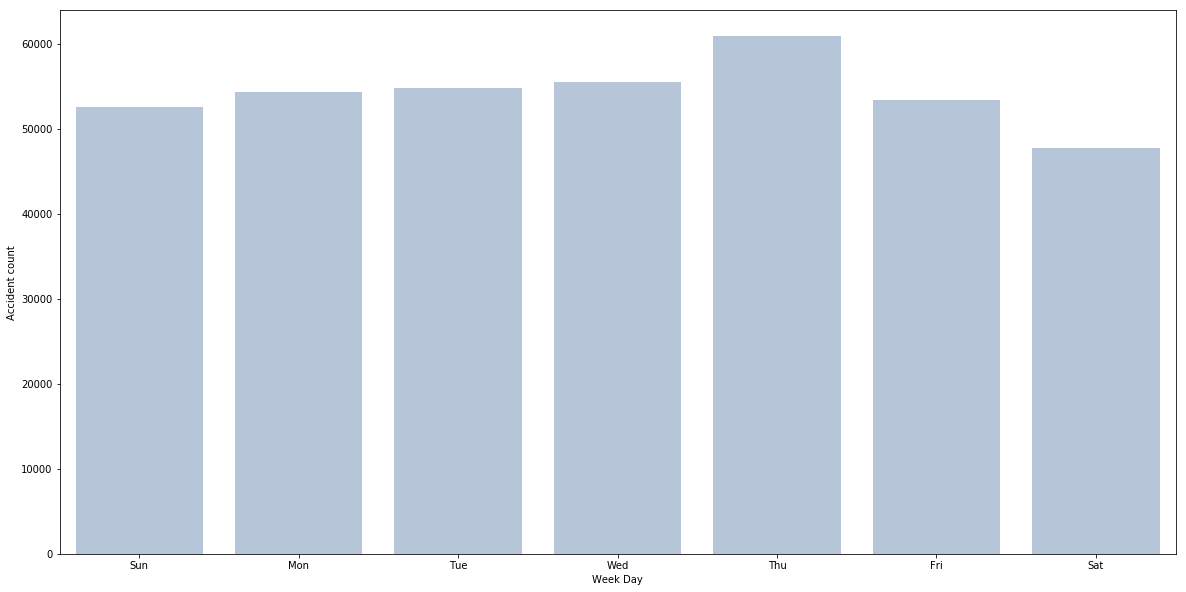

In [15]:
plt.figure(figsize=(20,10))
sns.barplot(x="Week Day", y="Accident count", color="lightsteelblue", data=week_df)

### Average Number of Accidents per Race and Hour

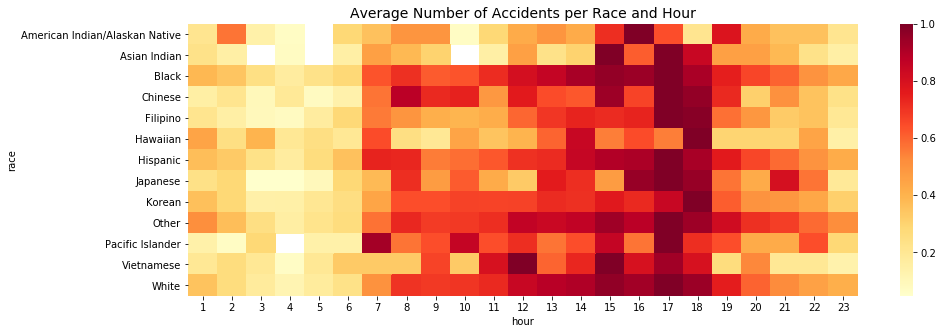

In [17]:
accidents_hour_pt = df.pivot_table(index='race', columns='hour', aggfunc='size')
accidents_hour_pt = accidents_hour_pt.apply(lambda x: x / accidents_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Race and Hour', fontsize=14)
sns.heatmap(accidents_hour_pt, cmap=p, cbar=True, annot=False, fmt=".0f");